In [1]:
pwd

'/mnt/md0/isshamie/Projects/Mito_Trace/workflow/notebooks/clone_af_dendrograms'

In [2]:
INDIR = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_prefilterMerge_impute/knn/kparam_30"
OUTDIR = "/data/Mito_Trace/output/pipeline/v04/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_prefilterMerge_impute/knn/kparam_30/barcodes/btwnClones_dendro_dt_dynamic_scrap"
DONOR = 0

dendroThresh = "dynamic"

# INDIR = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30"
# OUTDIR = "/data/Mito_Trace/output/pipeline/v02/CHIP_b1/MTBlacklist_A2/data/merged/MT/cellr_True/numread_200/filters/minC10_minR50_topN0_hetT0.001_hetC10_hetCount5_bq20/mgatk/vireoIn/clones/variants_init/knn/kparam_30/barcodes/btwnClones_dendro_dt_0.6"
# DONOR = 1
#dendroThresh = "dynamic" #0.6

verbose=False

mt_ref="/data/Mito_Trace/data/processed/genomes/mtMasked/GRCh38_MT_blacklist_A2_2020/chrM.fasta"

In [3]:
import src.utils.variant_utils as vu
import src.utils.dendro_clust as dc

import mplh.cluster_help as ch
import mplh.fig_utils as fu

from os.path import join, exists, dirname
from glob import glob
import pickle
import os
import vireoSNP
import numpy as np
from scipy import sparse
from scipy.io import mmread
import matplotlib.pyplot as plt
from scipy.stats import hypergeom
print(vireoSNP.__version__)
import pandas as pd
import seaborn as sns
from vireoSNP import Vireo
np.set_printoptions(formatter={'float': lambda x: format(x, '.5f')})
import scipy
from itertools import combinations
#from src.utils import utils  as ut

fig_utils from mplh
0.5.6


In [4]:
%load_ext autoreload
%autoreload 2

In [5]:
out_f = join(OUTDIR, f"donor{DONOR}")

### Load cells_meta 
### Create clones_meta - get number of cells in a clone and donor

In [6]:
cells_meta = pd.read_csv(join(INDIR, "cells_meta.tsv"), sep="\t")
cells_meta["lineage"] = cells_meta.apply(lambda x: f'{x["donor"]}_{x["lineage"]}', axis=1)
cells_meta

,ID,lineage,donor,condition
0,AAACTGCAGACTTCCA-1_Input,0_0,0,Input
1,AAACTGCTCCAACGCG-1_Input,0_0,0,Input
2,AAAGGATCAGATAAGT-1_Input,0_0,0,Input
3,AAAGGATTCCTGACCT-1_Input,0_0,0,Input
4,AAAGGGCTCGTTACAG-1_Input,0_0,0,Input
...,...,...,...,...
6604,TAGGTGTGTACGTAAA-1_Input,1_25,1,Input
6605,TCCCACAGTTCAGAAA-1_Input,1_25,1,Input
6606,TCTCAGCCAGCAATGG-1_Input,1_25,1,Input
6607,TGGGTGCAGCGCCTAC-1_Input,1_25,1,Input


In [7]:
conditions = cells_meta["condition"].unique()

In [8]:
clones_meta_df = pd.DataFrame(cells_meta.groupby("lineage").size(), columns=["size"]) #, index=["size"])
clones_meta_df["donor"] = [x.split("_")[0] for x in clones_meta_df.index]
clones_meta_df["donor"] = clones_meta_df["donor"].astype(int)
clones_meta_df

,size,donor
lineage,,
0_0,447,0
0_1,279,0
0_10,106,0
0_11,105,0
0_12,104,0
...,...,...
1_5,165,1
1_6,159,1
1_7,142,1


In [9]:
curr_clones = clones_meta_df[clones_meta_df["donor"]==DONOR]
# cells_meta = pd.read_csv(join(INDIR, "cells_meta.tsv"), sep='\t')#.sort_values(["donor", "lineage"])
curr_labels = cells_meta[cells_meta["donor"]==DONOR]

In [10]:
# curr_clones = clones_meta_df[clones_meta_df["donor"]==DONOR].set_index("lineage")
# curr_clones

## Load AF and DP

In [11]:
af_indir = join(INDIR, "sc_af", f"donor{DONOR}")
AF_df = pd.read_csv(join(af_indir, "af.tsv"), index_col=0, sep="\t")
DP_df = pd.read_csv(join(af_indir, "dp.tsv"), index_col=0, sep="\t")


### Functions to get mean and median

In [12]:
def calc_mean(cells, af):
    #print(cells.head())
    return af.loc[:,cells["ID"].values].mean(axis=1)

def calc_median(cells, af):
    #print(cells.head())
    return af.loc[:,cells["ID"].values].median(axis=1)

def calc_mean_with_coverage(cells, af, cov, min_cov=30):
    keep_inds = cov.loc[:, cells["ID"].values]
    keep_inds = keep_inds[keep_inds >= min_cov].columns
    return af.loc[:,keep_inds].mean(axis=1)

### Calculate clone-barcode mean

In [13]:
mean_af = curr_labels.groupby(["lineage"]).apply(calc_mean, af=AF_df)
anno = mean_af.reset_index()[["lineage"]]
mean_dp = curr_labels.groupby(["lineage"]).apply(calc_mean, af=np.log2(DP_df+1))
mean_dp = mean_dp.loc[mean_af.index, mean_af.columns]

mean_nocov_af = curr_labels.groupby(["lineage"]).apply(calc_mean_with_coverage, af=AF_df, cov=DP_df)
#anno_dp = mean_dp.reset_index()[["lineage"]]
# na_cells = curr_labels.loc[curr_labels["lineage"].isnull()]
# na_mean_af = na_cells.groupby("condition").apply(calc_mean, af=AF_df)

# if not (na_mean_af.shape[0] == 0):
#     print('na shape', na_mean_af.shape)
#     na_anno = pd.concat((anno,pd.DataFrame({"lineage":["None"]*len(na_mean_af.index)})), ignore_index=True)
#     na_concat = pd.concat((mean_af.reset_index(drop=True), na_mean_af.reset_index(drop=True)), ignore_index=True)
#     na_mean_dp = na_cells.groupby("condition").apply(calc_mean, af=np.log2(DP_df+1))
#     na_dp_concat = pd.concat((mean_dp, na_mean_dp.reset_index(drop=True)), ignore_index=True)
# else:
#     na_anno = anno
#     na_concat = mean_af.reset_index(drop=True)
#     na_dp_concat = mean_dp
     
mean_af  

Variant,146A,709A,930A,1413A,1888A,1949A,2442A,2514A,2857A,3242A,...,15607G,16519G,2623T,3735T,7361T,7485T,7639T,12283T,16294T,16296T
lineage,,,,,,,,,,,,,,,,,,,,,
0_0,7.961701e-07,0.003577,0.003781,0.000211,0.004577,0.000618,0.000181,0.004234,0.000000,0.005276,...,0.007020,0.000281,0.000091,0.003447,0.003110,0.000193,0.003139,0.002216,0.000995,0.000324
0_1,2.530044e-04,0.000924,0.000450,0.000264,0.000148,0.000472,0.000171,0.000000,0.000146,0.000082,...,0.000643,0.000000,0.000255,0.000172,0.000129,0.000226,0.001165,0.000500,0.000234,0.000181
0_10,2.858776e-04,0.000281,0.000526,0.000071,0.001198,0.002033,0.000000,0.001163,0.000166,0.000074,...,0.000981,0.000230,0.000000,0.001137,0.002125,0.000091,0.000571,0.000818,0.000000,0.000248
0_11,4.981328e-04,0.001591,0.002227,0.000000,0.000220,0.002717,0.000000,0.000858,0.000000,0.000102,...,0.001919,0.000000,0.000000,0.000984,0.001027,0.000000,0.007380,0.013708,0.000235,0.000235
0_12,1.711000e-06,0.002170,0.001744,0.000000,0.003174,0.279984,0.000401,0.001624,0.000604,0.000000,...,0.001648,0.000000,0.000818,0.002539,0.002412,0.000000,0.001146,0.002388,0.001872,0.002180
0_13,0.000000e+00,0.003968,0.000508,0.000000,0.001755,0.001019,0.000000,0.001379,0.000000,0.000000,...,0.003953,0.000800,0.000147,0.000538,0.002017,0.000000,0.000921,0.001781,0.000250,0.000253
0_14,2.148228e-04,0.000489,0.001340,0.000000,0.000962,0.001489,0.000000,0.000734,0.000917,0.000638,...,0.002194,0.000177,0.000000,0.000816,0.001745,0.000173,0.002511,0.001789,0.000592,0.000615
0_15,1.853584e-06,0.001190,0.001967,0.000000,0.000580,0.017700,0.000000,0.000872,0.000237,0.010217,...,0.001658,0.000000,0.000193,0.000208,0.001172,0.000193,0.002319,0.001018,0.000210,0.000213
0_16,1.955429e-06,0.002674,0.001730,0.000403,0.003232,0.002667,0.000000,0.000970,0.000147,0.006349,...,0.001899,0.000000,0.002165,0.001715,0.001258,0.000366,0.002400,0.001022,0.000000,0.000000


In [14]:
### Cluster to get dendro results
# if mean_af.shape[0] == 1 or  mean_af.shape[1] == 1 :
#     print('no clustering needed only one var')
# else:
#     g = sns.clustermap(mean_af, row_cluster=True, col_cluster=True, vmax=0.2, vmin=0)
#     inds = g.dendrogram_row.dendrogram["leaves"]
#     cols = g.dendrogram_col.dendrogram["leaves"]
#     curr_clones = curr_clones.iloc[inds]
#     plt.close(g.fig)

### Cluster and calculate proper size

In [15]:
# %matplotlib inline
# if not (mean_af.shape[0] == 1 or  mean_af.shape[1] == 1 ):
#     if dendroThresh == "dynamic":
#         clusters, link = dc.run_dynamic_hyper(np.sqrt(np.clip(mean_af, 0, 0.4)))
#         #clusters, link = dc.run_dynamic_hyper(np.sqrt(mean_af))
#         #clusters, link = dc.run_dynamic(mean_af, metric='euclidean', method="average", minClusterSize=1)
#         curr_clones["den_clust"] = curr_clones.apply(lambda x: f'C{clusters.loc[x.name, "labels"]}', axis=1)
#     else:
#         den = dc.dendro_cluster(mean_af, g, d_thresh=dendroThresh)
#         curr_clones = dc.add_cluster_labels(den,curr_clones)
#         curr_clones

#     size_pvals = dc.cluster_stats(curr_clones, out_f= out_f )

#     curr_clones["donor"]= [x.split("_")[0] for x in curr_clones.index]
#     curr_clones = curr_clones.loc[mean_af.index]
# else:
#     with open(out_f+".dendrogram_pvals.txt", "w") as f:
#         f.write("no cells")
    

# ## Group clones using dendrogram and run stats on size differences in the groups
# linkage is from dynamic dendrogram clustering based on "np.sqrt(np.clip(mean_af, 0, 0.4))"

# ## Plot with dendro clusters

# if not (mean_af.shape[0] == 1 or  mean_af.shape[1] == 1 ):
#     g = ch.plot_cluster(mean_af,row_meta=curr_clones, to_row_clust=True, to_col_clust=True,
#                         col_meta=variants_df[["variant type", "variant change"]], col_clr_schemes="categorical",
#                         row_clr_schemes={"size":"sequential","donor":"categorical","den_clust":"categorical"}, 
#                         vmax=0.2, vmin=0, cmap="rocket_r",
#                         row_linkage=link)
#     plt.suptitle("Donor sqrt allele-frequency heatmap with clone and condition labels (max AF=0.2)")
#     #fu.helper_save(out_f+"withEnrichmentFoldChange.NoCondition.clust.max2.AF.png",to_pdf=False)
#     fu.helper_save(out_f+".dendro.NoCondition.max2.AF.png",to_pdf=True, to_svg=True)

#     inds = g.dendrogram_row.dendrogram["leaves"]
#     cols = g.dendrogram_col.dendrogram["leaves"]

    
#     g1d = ch.plot_cluster(mean_dp.iloc[inds, cols], row_meta=curr_clones, to_row_clust=False, to_col_clust=False,
#                           row_clr_schemes={"size":"sequential","donor":"categorical","den_clust":"categorical"}, 
#                           col_meta=variants_df[["variant type", "variant change"]], col_clr_schemes="categorical",
#                           cmap="rocket_r")
#     g1d.ax_cbar.set_title("log2(reads+1)")
#     fu.helper_save(out_f+".dendro.NoCondition.DP.png",to_pdf=True, to_svg=True)#, f=g1d.figure)


#     mean_af = mean_af.iloc[inds,cols]
#     curr_clones = curr_clones.loc[mean_af.index]

#     ch.plot_cluster(mean_af,row_meta=curr_clones, row_linkage=link, to_col_clust=False,
#                     col_meta=variants_df[["variant type", "variant change"]], col_clr_schemes="categorical",
#                     row_clr_schemes={"size":"sequential","donor":"categorical","den_clust":"categorical"}, 
#                     vmax=0.5, vmin=0, cmap="rocket_r")
#     plt.suptitle("Donor sqrt allele-frequency heatmap with clone and condition labels (max AF=0.5)")
#     #fu.helper_save(out_f+"withEnrichmentFoldChange.NoCondition.clust.max5.AF.png",to_pdf=False)
#     fu.helper_save(out_f+".dendro.NoCondition.max5.AF.png",to_pdf=True, to_svg=True)

# else:
#     f = plt.figure()
#     plt.title("no cells")
#     f.savefig(out_f+".dendro.NoCondition.max2.AF.png")


### Save mean_af and curr_clonnes
# curr_clones.to_csv(out_f+".clones_dendro.csv")
# mean_af.to_csv(out_f+".initInds.mean.csv")

# curr_clones[["donor","size", "log2_fold","-log10(fold p_adj)", "shuffle_sig", 
#              "ncells"]+ list(curr_labels["condition"].unique())].to_csv(out_f+".initInds.indsMeta.csv")

## Remove the 0s

distances
[0.29310 0.00086 0.29381 0.10375 0.29238 0.00181 0.29172 0.29521 0.49418
 0.31074 0.29426 0.00051 0.48048 0.30297 0.00585 0.02753 0.00250 0.29516
 0.29298 0.29559 0.00423 0.29551 0.00081 0.00700 0.31608 0.30090 0.18423
 0.49156 0.49979 0.00079 0.29301 0.29330 0.10452 0.29160 0.29246 0.29278
 0.00396 0.36565 0.00775 0.29347 0.00360 0.00716 0.29259 0.03110 0.00300
 0.29268 0.29333 0.02215 0.29677 0.31251 0.29381 0.00636 0.00359 0.00607
 0.29539 0.00431 0.29251 0.29741 0.04266 0.01458 0.42277 0.29301 0.29277
 0.29252 0.00497 0.00333 0.05293 0.00555 0.00191 0.29310 0.10269 0.29357
 0.00173 0.29188 0.29579 0.49230 0.30937 0.29409 0.00055 0.49273 0.30371
 0.00613 0.02633 0.00230 0.29588 0.29290 0.29615 0.00433 0.29565 0.00055
 0.00726 0.31843 0.30294 0.18439 0.49451 0.50023 0.00044 0.29377 0.29372
 0.10505 0.29261 0.29285 0.36418 0.01065 0.29465 0.00678 0.01008 0.28977
 0.03404 0.00592 0.29416 0.29344 0.02428 0.29767 0.31295 0.29474 0.00962
 0.00736 0.00927 0.29657 0.00771 0.29427 

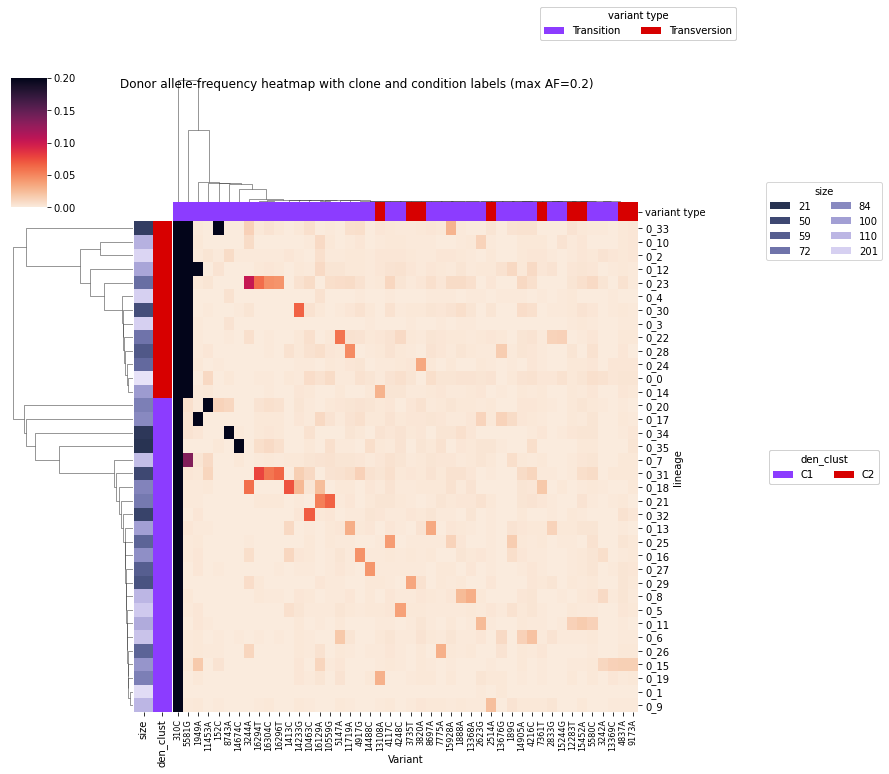

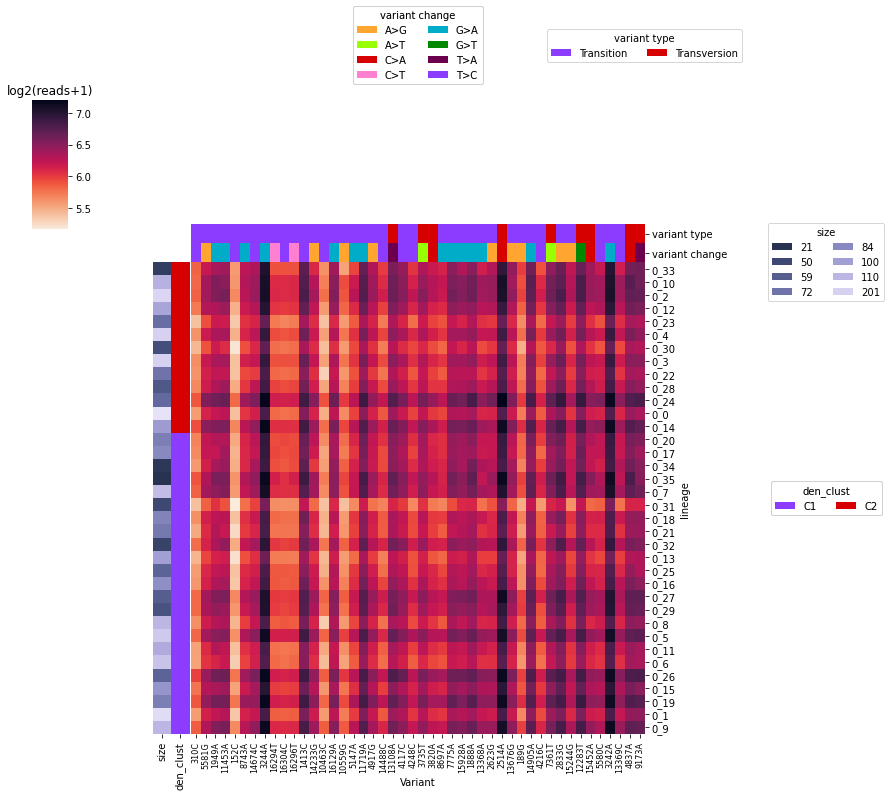

In [21]:
out_f_rmLow = out_f + ".rmLowVars"

mean_rmLow_af = mean_af.copy().loc[:,~(mean_af<0.01).all(axis=0)]
mean_rmLow_dp = mean_dp.loc[mean_rmLow_af.index, mean_rmLow_af.columns]

# Get variant types
variants_df = vu.add_ref_to_variants(variants=mean_rmLow_af.columns.values,
                                     mt_df=vu.load_mt_ref(mt_ref))
variants_df = vu.type_of_variants(variants_df, to_preproc=False)


%matplotlib inline
if not (mean_rmLow_af.shape[0] == 1 or  mean_rmLow_af.shape[1] == 1 ):
    if dendroThresh == "dynamic":
        clusters, link = dc.run_dynamic_hyper(np.clip(mean_rmLow_af, 0, 0.4))
        #clusters, link = dc.run_dynamic_hyper(np.sqrt(mean_rmLow_af))
        
        #clusters, link = dc.run_dynamic(mean_rmLow_af, metric='euclidean', method="average", minClusterSize=1)
        curr_clones["den_clust"] = curr_clones.apply(lambda x: f'C{clusters.loc[x.name, "labels"]}', axis=1)
    else:
        den = dc.dendro_cluster(mean_rmLow_af, g, d_thresh=dendroThresh)

        if verbose:
            print('icoord and color list')
            print(len(den["icoord"]))
            print(len(den["color_list"]))
            print('leaves leaves color and mean_rmLow_af shape')
            print(len(den["leaves"]))
            print(len(den["leaves_color_list"]))
            print(mean_rmLow_af.shape)
        # cluster_classes = dc.get_cluster_classes(den)
        curr_clones = dc.add_cluster_labels(den,curr_clones)
        curr_clones

    size_pvals = dc.cluster_stats(curr_clones, out_f= out_f )

    curr_clones["donor"]= [x.split("_")[0] for x in curr_clones.index]
    curr_clones = curr_clones.loc[mean_rmLow_af.index]

    # with open(out_f + ".dendrogram_pvals.txt", "w") as f:
    #     #for l in size_pvals:
    #     f.write("\n".join(size_pvals))
else:
    with open(out_f+".dendrogram_pvals.txt", "w") as f:
        f.write("no cells")
    
curr_clones.loc[mean_rmLow_af.index]
variants_df.loc[mean_rmLow_af.columns]

curr_clones = curr_clones.drop("donor", axis=1)

if not (mean_rmLow_af.shape[0] == 1 or  mean_rmLow_af.shape[1] == 1 ):
    g = ch.plot_cluster(mean_rmLow_af, row_meta=curr_clones[["size", "den_clust"]], 
                        to_row_clust=True, to_col_clust=True,
                        row_clr_schemes={"size":"sequential","den_clust":"categorical"}, 
                        col_meta=variants_df.loc[mean_rmLow_af.columns,["variant type"]], 
                        col_clr_schemes="categorical",
                        vmax=0.2, vmin=0, cmap="rocket_r", yticklabels=1, xticklabels=1
                        )
    plt.suptitle("Donor allele-frequency heatmap with clone and condition labels (max AF=0.2)")
    #fu.helper_save(out_f_rmLow+"withEnrichmentFoldChange.NoCondition.clust.max2.AF.png",to_pdf=False)
    fu.helper_save(out_f_rmLow+".dendro.NoCondition.max2.AF.png",to_pdf=True)

    inds = g.dendrogram_row.dendrogram["leaves"]
    cols = g.dendrogram_col.dendrogram["leaves"]
    mean_rmLow_af = mean_rmLow_af.iloc[inds, cols]
    g1d = ch.plot_cluster(mean_rmLow_dp.iloc[inds, cols], row_meta=curr_clones[["size", "den_clust"]], 
                          to_row_clust=False, to_col_clust=False,
                          row_clr_schemes={"size":"sequential","den_clust":"categorical"}, 
                          col_meta=variants_df[["variant type", "variant change"]], col_clr_schemes="categorical",
                          cmap="rocket_r", yticklabels=1, xticklabels=1
                         )
    g1d.ax_cbar.set_title("log2(reads+1)")
    fu.helper_save(out_f_rmLow+".dendro.NoCondition.DP.png",to_pdf=True)#, f=g1d.figure)

    #curr_clones = curr_clones.loc[mean_rmLow_af.index]

#     ch.plot_cluster(np.sqrt(mean_rmLow_af),row_meta=curr_clones, to_row_clust=False, to_col_clust=False,
#                     col_meta=variants_df[["variant type", "variant change"]], col_clr_schemes="categorical",
#                     row_clr_schemes={"size":"sequential","donor":"categorical","den_clust":"categorical"}, 
#                     vmax=0.5, vmin=0, cmap="rocket_r")
#     plt.suptitle("Donor sqrt allele-frequency heatmap with clone and condition labels (max AF=0.5)")
#     #fu.helper_save(out_f_rmLow+"withEnrichmentFoldChange.NoCondition.clust.max5.AF.png",to_pdf=False)
#     fu.helper_save(out_f_rmLow+".dendro.NoCondition.max5.AF.png",to_pdf=True)

else:
    f = plt.figure()
    plt.title("no cells")
    f.savefig(out_f_rmLow+".dendro.NoCondition.max2.AF.png")





mean_rmLow_af.to_csv(out_f_rmLow + ".af.mean.csv")

In [22]:
mean_rmLow_af

Variant,310C,5581G,1949A,11453A,152C,8743A,14674C,3244A,16294T,16304C,...,7361T,2833G,15244G,12283T,15452A,5580C,3242A,13369C,4837A,9173A
lineage,,,,,,,,,,,,,,,,,,,,,
0_33,0.902840,0.830535,0.001063,0.000000,0.805795,0.000000,0.000000,0.014029,0.002245,0.004496,...,0.000470,0.000000,0.000000,0.003922,0.002324,0.001347,0.000978,0.000527,0.001748,0.002622
0_10,0.888522,0.667069,0.002033,0.000000,0.000139,0.000000,0.000000,0.008205,0.000000,0.000000,...,0.002125,0.000183,0.004586,0.000818,0.002642,0.000280,0.000074,0.000279,0.002065,0.002608
0_2,0.909892,0.410807,0.001169,0.003255,0.001143,0.007905,0.001161,0.000894,0.000993,0.001111,...,0.002509,0.000786,0.000313,0.001226,0.002359,0.001738,0.004366,0.002580,0.001689,0.002437
0_12,0.891270,0.773325,0.279984,0.000506,0.004148,0.000385,0.000603,0.000125,0.001872,0.002557,...,0.002412,0.004079,0.000000,0.002388,0.003230,0.003114,0.000000,0.000836,0.002045,0.001354
0_23,0.747083,0.854792,0.002074,0.003490,0.000110,0.000000,0.000000,0.102953,0.061330,0.045818,...,0.000000,0.000000,0.000000,0.003336,0.005840,0.009306,0.003218,0.000000,0.005284,0.001454
0_4,0.852339,0.995061,0.000233,0.000086,0.000038,0.004894,0.000200,0.000296,0.000296,0.000335,...,0.001004,0.000141,0.000967,0.001635,0.000724,0.000633,0.000504,0.001522,0.000556,0.000443
0_30,0.897327,0.932034,0.000710,0.000950,0.000000,0.000475,0.001376,0.003312,0.000000,0.000639,...,0.000772,0.000900,0.000842,0.001993,0.004298,0.002608,0.000000,0.001226,0.001574,0.001195
0_3,0.945153,0.970629,0.001246,0.000748,0.000196,0.004585,0.000000,0.000072,0.000082,0.000691,...,0.000605,0.000089,0.000429,0.000901,0.001911,0.000839,0.000187,0.000400,0.001169,0.001338
0_22,0.893818,0.931456,0.000917,0.000683,0.000213,0.000931,0.000000,0.005757,0.000521,0.001441,...,0.001455,0.012856,0.013889,0.000590,0.001516,0.002518,0.000718,0.000292,0.001619,0.001634
